In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt

if not os.path.exists(os.path.join(os.getcwd(), 'config.json')):
  # preventing to go always to the parent folder everytime we run the jupyter notebook without restarting
  os.chdir("..")
if not os.getcwd() in sys.path:
  sys.path.append(os.getcwd())

from analysis.analysis_commons import *
from labeler.database_labeler import label_database
from loaders.prepare_lite_db import prepare_lite_db
from graph import Graph
from analysis.analysis_commons import * 
from rank import Rank
from strategies import RandomStrategy 
from analysis.analysis_commons import create_simulation_name

config = None
with open('config.json') as config_file:
  config = json.load(config_file)

# ---------------------------------------------------
config["database"]["database"] = "nellie_hist_crawl"
# ---------------------------------------------------

topic = 'Nellie Ohr'
topic_data = None

flipped = False

with open('data/datavoids_per_topic_filtered.json', 'r') as f:
  dv_per_topic = json.load(f)
  topic_data=dv_per_topic[topic]

if flipped:
  mitigator_id = topic_data["disinformer_id"] 
  disinformer_id = topic_data["mitigator_id"]
  mitigator_label = topic_data["disinformer"]
  disinformer_label = topic_data["mitigator"]
else:
  mitigator_id = topic_data["mitigator_id"]
  disinformer_id = topic_data["disinformer_id"] 
  mitigator_label = topic_data["mitigator"]
  disinformer_label = topic_data["disinformer"] 

datavoids = topic_data["datavoids"] 

config = clone_config_with_target(config, mitigator_label, disinformer_label, mitigator_id, disinformer_id)

config['datavoids'] = [ datavoids ]
print("Datavoids:", config['datavoids'])
keyword = config["datavoids"][0]
if isinstance(keyword, list):
  keyword = "|".join(keyword)
print("Keyword:", keyword)

config['topic_name'] = 'Historical Crawled Data'

number_of_runs = 15

Datavoids: [['funded', 'company', 'material', 'nunes', 'concerns', 'jeff', 'devin', 'author', 'congressional', 'secret', 'collusion']]
Keyword: funded|company|material|nunes|concerns|jeff|devin|author|congressional|secret|collusion


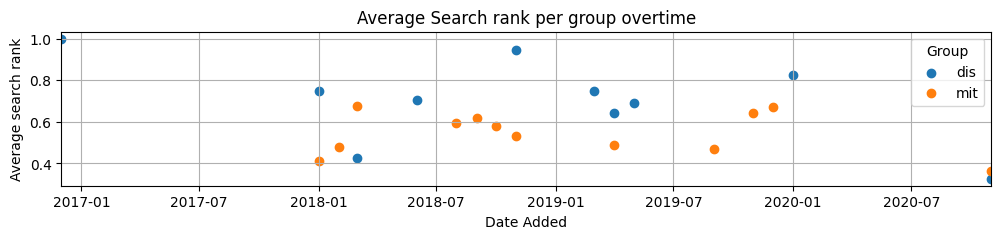

In [2]:
# Connect to your postgres DB
conn = psycopg2.connect(**config["database"])

cur = conn.cursor()

query = """
    select date_added, avg(searchrank) as avg_rank, grp 
    from nodes_info 
    natural join rank 
    natural join nodes 
    where grp is not null 
    group by date_added, grp 
    order by date_added;
"""
cur.execute(query)
data = cur.fetchall()
cur.close()
conn.close()

df = pd.DataFrame(data, columns=["date_added", "avg_rank", "grp"])
df['date_added'] = pd.to_datetime(df['date_added'])
pivot_df = df.pivot(index='date_added', columns='grp', values='avg_rank')

plt.figure(figsize=(12, 2))

plt.xlim(df['date_added'].min(), df['date_added'].max())

# Plotting each group as a scatter plot (dotted plot)
for column in pivot_df.columns:
  plt.scatter(pivot_df.index, pivot_df[column], label=column, marker='o')

plt.xlabel("Date Added")
plt.ylabel("Average search rank")
plt.title("Average Search rank per group overtime")
plt.legend(title="Group")
plt.grid(True)
plt.show()

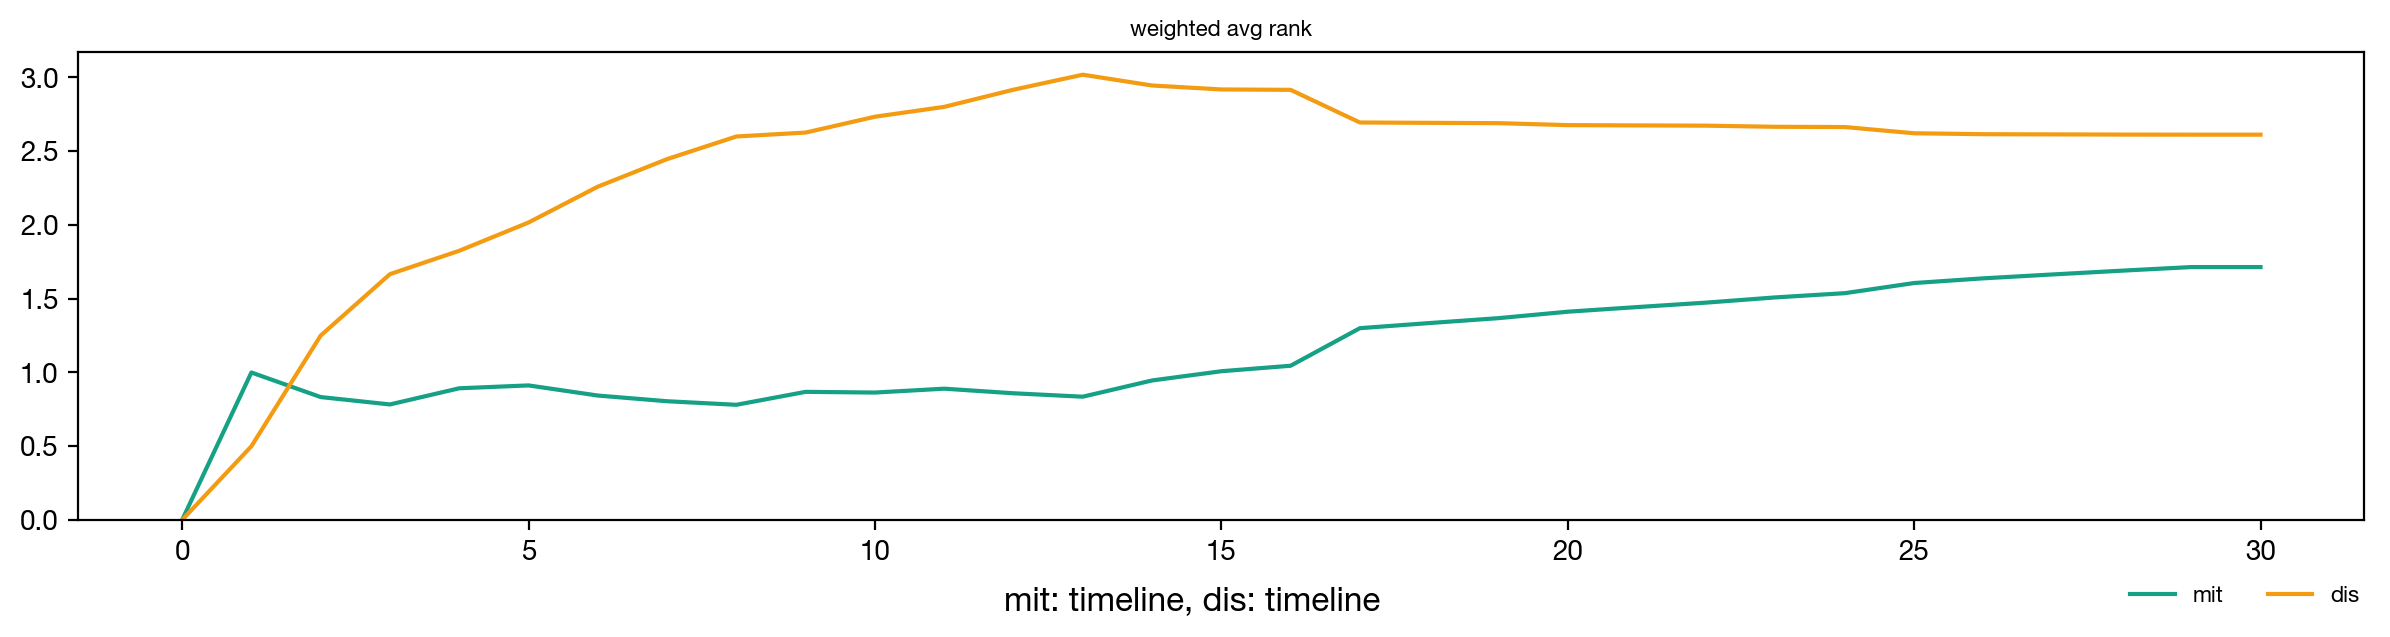

In [3]:
mitigator_strategy = TimeLineStrategy()
disinformer_strategy = TimeLineStrategy()
simulation_label = 'nellie-ohr-' + mitigator_strategy.get_strategy_name() + '-' + disinformer_strategy.get_strategy_name() + '-base'
output_filename = run_simple_simulation(
  keyword, 
  mitigator_strategy, 
  disinformer_strategy, 
  simulation_label, 
  config, 
  mute_output=True, 
  delete_results_if_exist=False,
  number_of_runs=number_of_runs,
  delete_tsrank=True,
  delete_pagerank=False # important to keep this false, because pagerank is loaded from Moz
)
config["output_filename"] = output_filename 
steps_per_strategy_base, strategies_base, id_max_rank_base = get_output(config)
fig = plot_results_for_steps_per_strategy(strategies_base[0], steps_per_strategy_base, config, filter_groups=['None'], show=False)

In [7]:
last_step = max(steps_per_strategy_base[strategies_base[0]].keys())

mit_ranks = steps_per_strategy_base[strategies_base[0]][last_step][mitigator_label]['weighted_avg_rank']
dis_ranks = steps_per_strategy_base[strategies_base[0]][last_step][disinformer_label]['weighted_avg_rank']
print(f"Mitigator ({mitigator_label}) wavgrank: {sum(mit_ranks) / len(mit_ranks):.2f}")
print(f"Disinformer ({disinformer_label}) wavgrank: {sum(dis_ranks) / len(dis_ranks):.2f}")

Mitigator (mit) wavgrank: 1.71
Disinformer (dis) wavgrank: 2.61


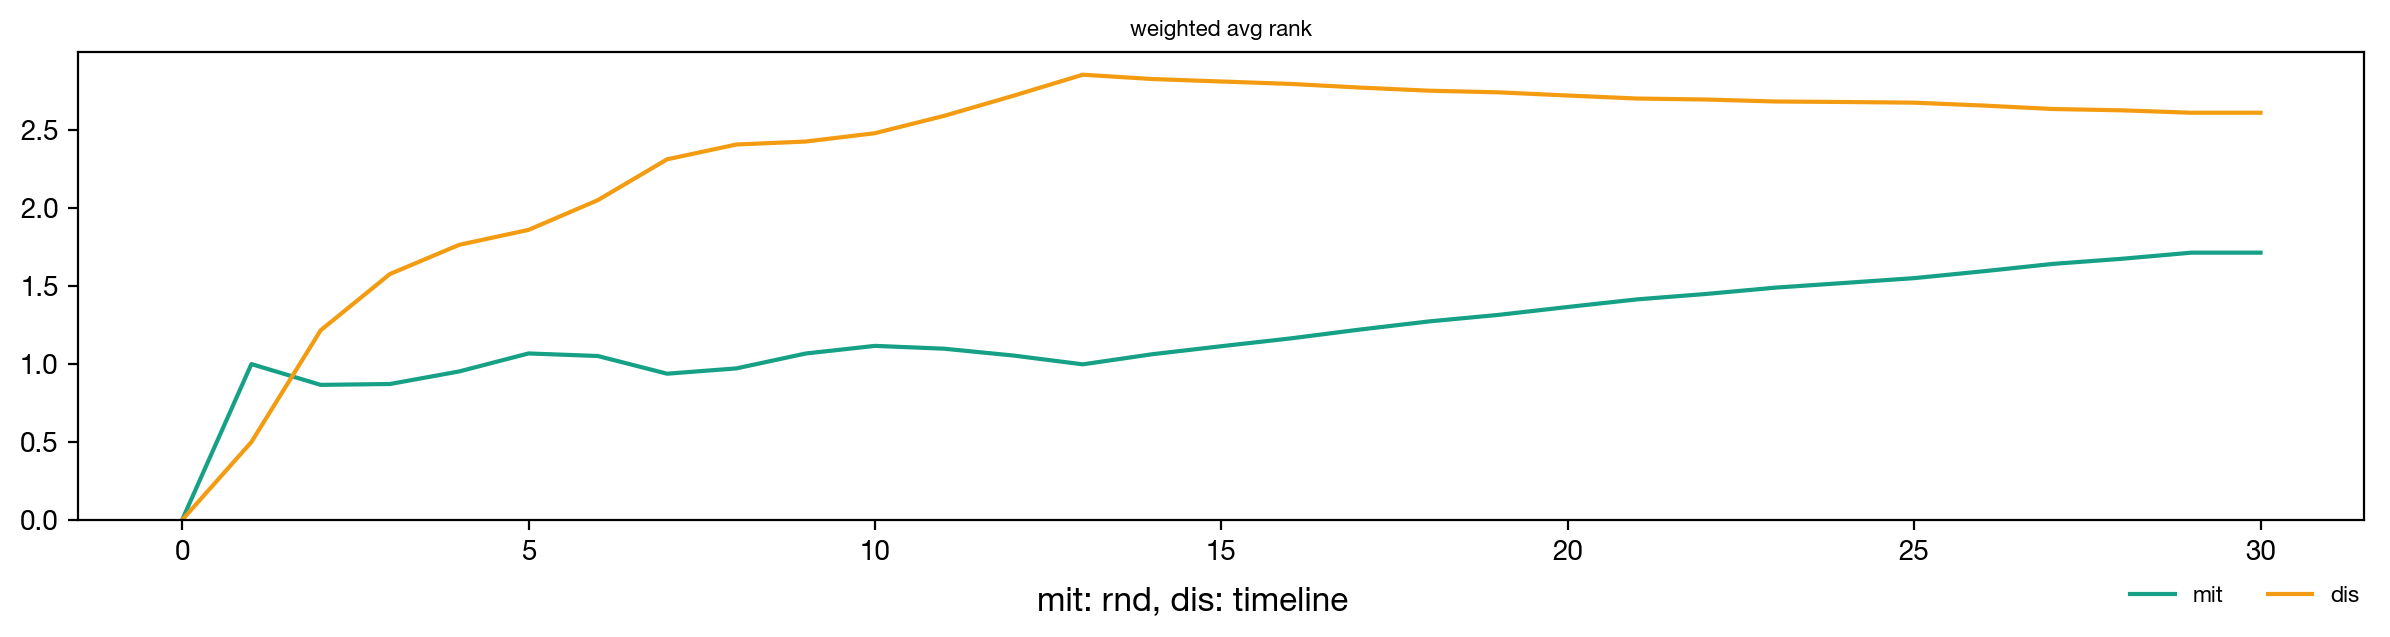

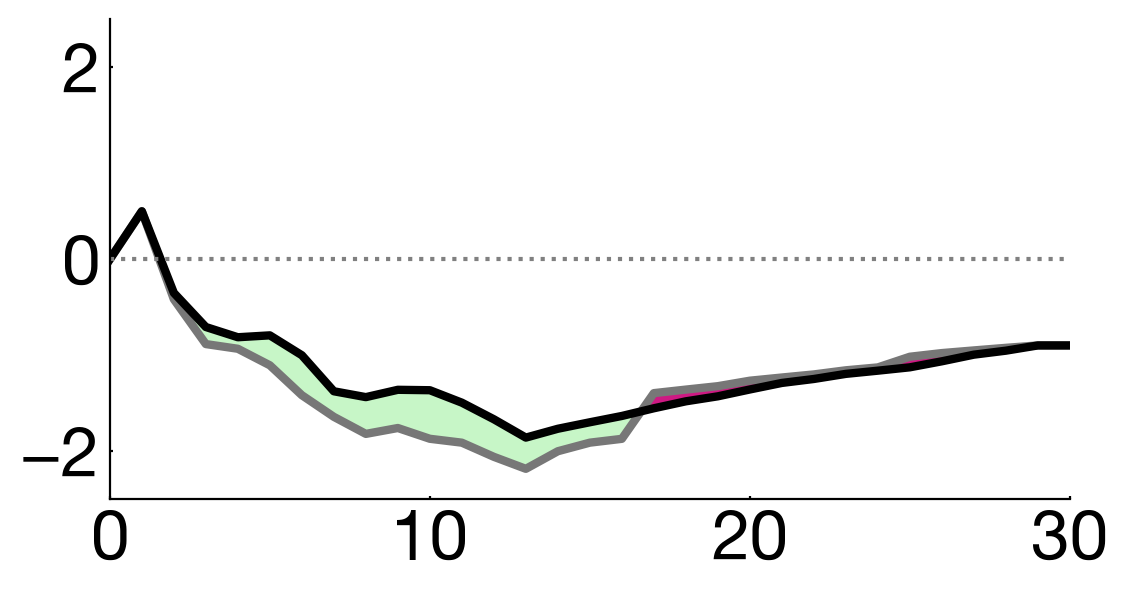

In [4]:
mitigator_strategy = RandomStrategy()
disinformer_strategy = TimeLineStrategy()
simulation_label = 'nellie-ohr-' + mitigator_strategy.get_strategy_name() + '-' + disinformer_strategy.get_strategy_name()
output_filename = run_simple_simulation(
  keyword, 
  mitigator_strategy, 
  disinformer_strategy, 
  simulation_label, 
  config, 
  mute_output=True, 
  delete_results_if_exist=False,
  number_of_runs=number_of_runs,
  delete_tsrank=True,
  delete_pagerank=False # important to keep this false, because pagerank is loaded from Moz
)
config["output_filename"] = output_filename 
steps_per_strategy, strategies, id_max_rank = get_output(config)
plot_results_for_steps_per_strategy(strategies[0], steps_per_strategy, config, filter_groups=['None'])
fig = plot_differences_against_opponent_base(
  None,
  mitigator_label,
  disinformer_label,
  strategies_base[0],
  strategies[0], 
  steps_per_strategy_base, 
  steps_per_strategy, 
  config,
  y_min=-2.5,
  y_max=2.5,
  show=True,
  show_legend=False
)
img_filename = output_filename.replace(".csv", ".pdf").replace('results/', 'results/images_historical_crawled_data/')
fig.savefig(img_filename, bbox_inches='tight')

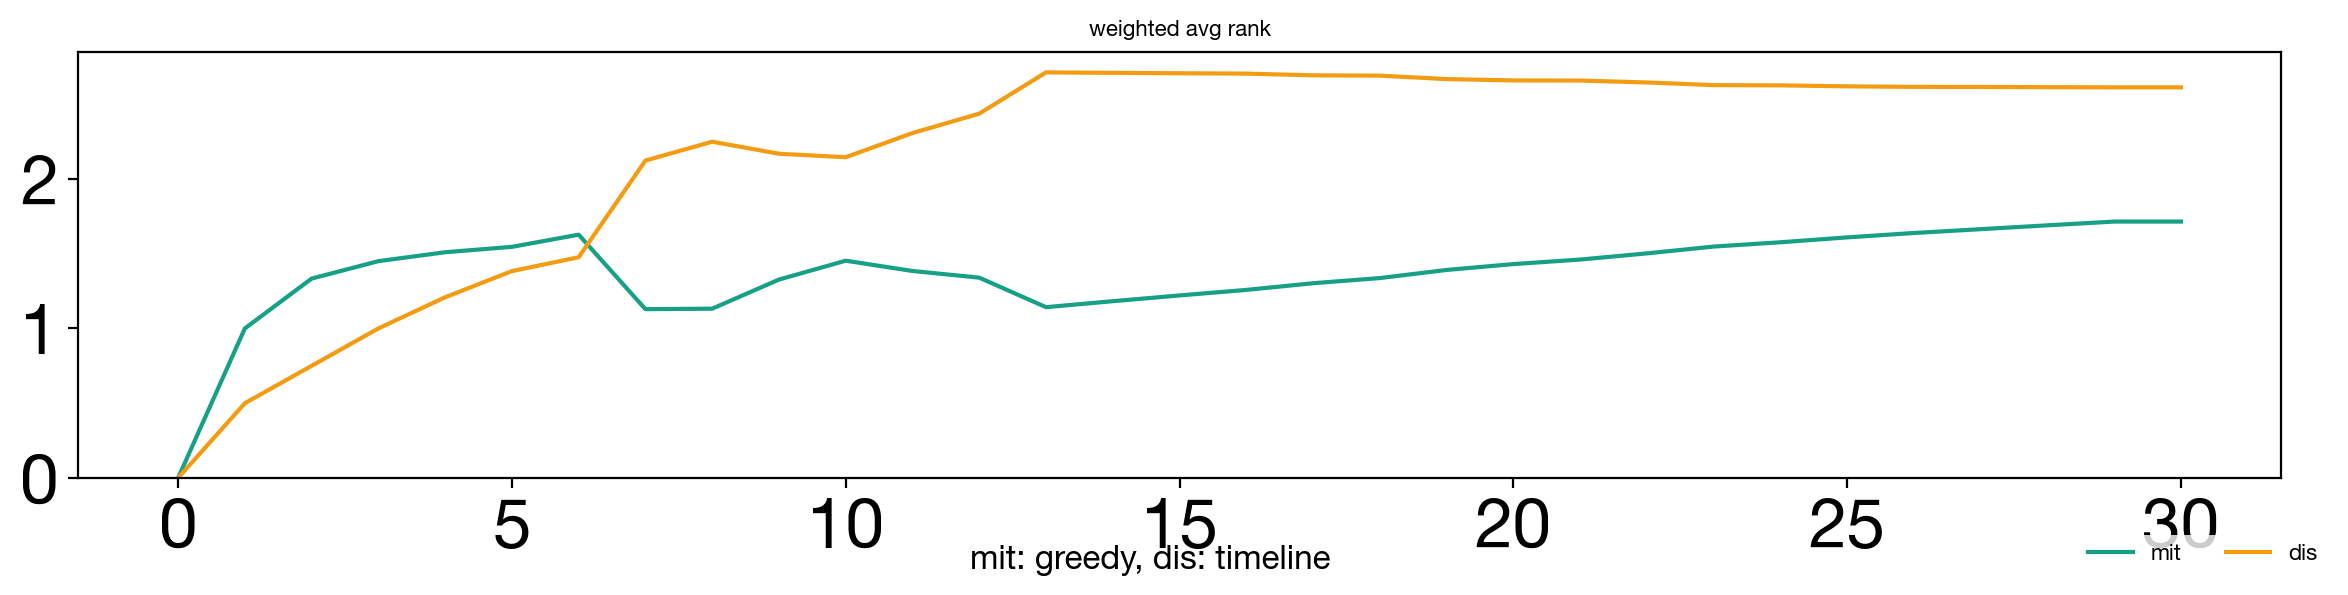

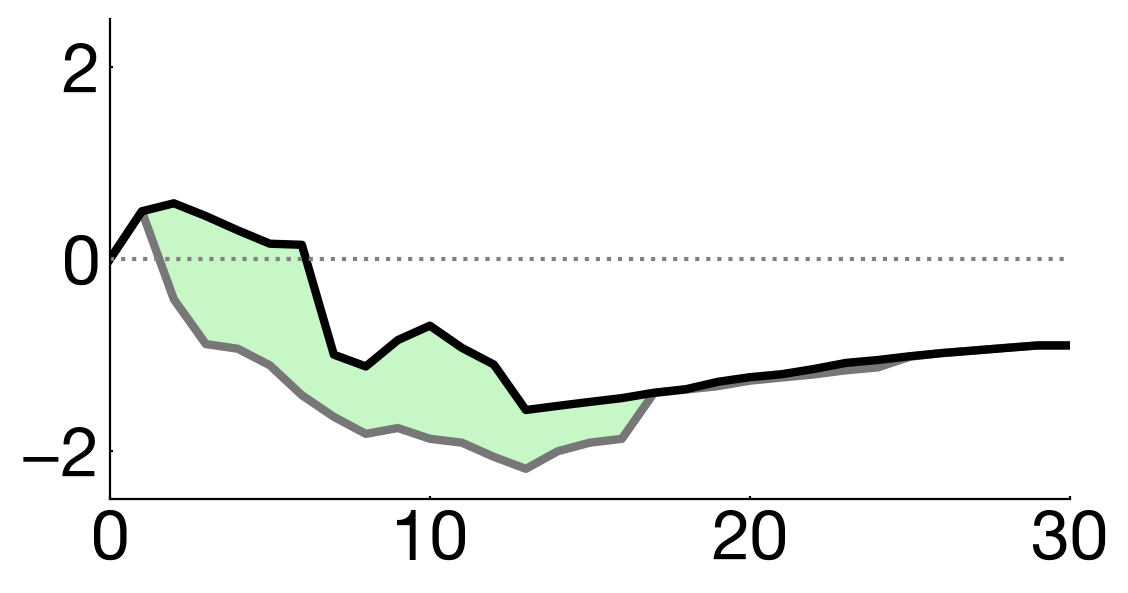

In [5]:
mitigator_strategy = GreedyStrategy(True)
disinformer_strategy = TimeLineStrategy()
simulation_label = 'nellie-ohr-' + mitigator_strategy.get_strategy_name() + '-' + disinformer_strategy.get_strategy_name()
output_filename = run_simple_simulation(
  keyword, 
  mitigator_strategy, 
  disinformer_strategy, 
  simulation_label, 
  config, 
  mute_output=True, 
  delete_results_if_exist=False,
  number_of_runs=number_of_runs,
  delete_tsrank=True,
  delete_pagerank=False # important to keep this false, because pagerank is loaded from Moz
)
config["output_filename"] = output_filename 
steps_per_strategy, strategies, id_max_rank = get_output(config)
plot_results_for_steps_per_strategy(strategies[0], steps_per_strategy, config, filter_groups=['None'])
fig = plot_differences_against_opponent_base(
  None,
  mitigator_label,
  disinformer_label,
  strategies_base[0],
  strategies[0], 
  steps_per_strategy_base, 
  steps_per_strategy, 
  config,
  y_min=-2.5,
  y_max=2.5,
  show=True,
  show_legend=False
)
img_filename = output_filename.replace(".csv", ".pdf").replace('results/', 'results/images_historical_crawled_data/')
fig.savefig(img_filename, bbox_inches='tight')

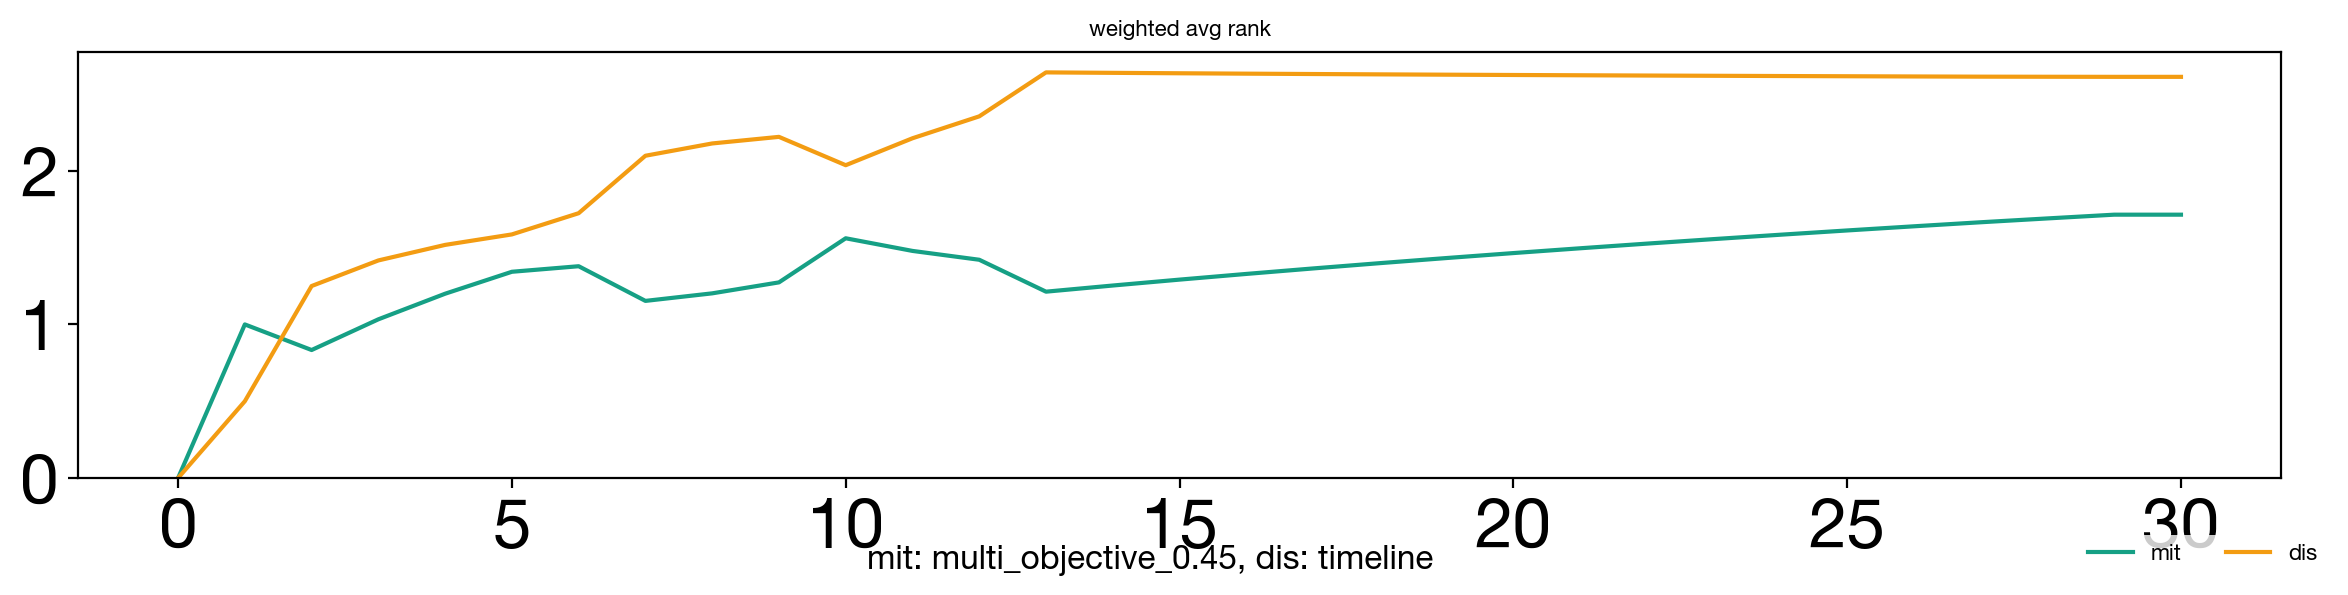

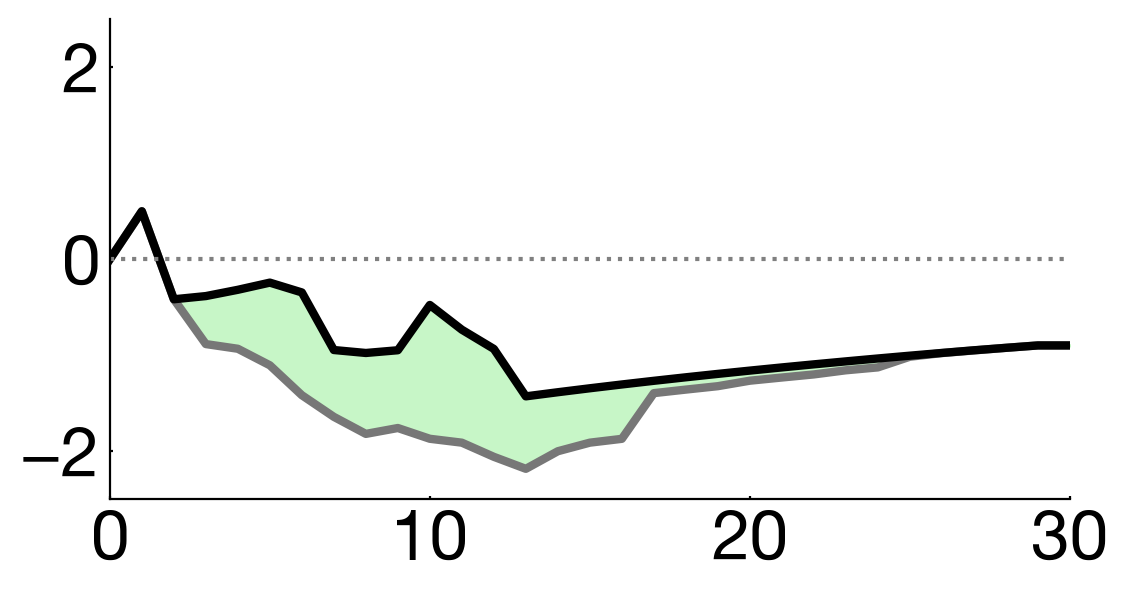

In [6]:
mitigator_strategy = MultiObjectiveStrategy(0.45)
disinformer_strategy = TimeLineStrategy()
simulation_label = 'nellie-ohr-' + mitigator_strategy.get_strategy_name() + '-' + disinformer_strategy.get_strategy_name()
output_filename = run_simple_simulation(
  keyword, 
  mitigator_strategy, 
  disinformer_strategy, 
  simulation_label, 
  config, 
  mute_output=True, 
  delete_results_if_exist=False,
  number_of_runs=number_of_runs,
  delete_tsrank=True,
  delete_pagerank=False # important to keep this false, because pagerank is loaded from Moz
)
config["output_filename"] = output_filename 
steps_per_strategy, strategies, id_max_rank = get_output(config)
plot_results_for_steps_per_strategy(strategies[0], steps_per_strategy, config, filter_groups=['None'])
fig = plot_differences_against_opponent_base(
  None,
  mitigator_label,
  disinformer_label,
  strategies_base[0],
  strategies[0], 
  steps_per_strategy_base, 
  steps_per_strategy, 
  config,
  y_min=-2.5,
  y_max=2.5,
  show=True,
  show_legend=False
)

img_filename = output_filename.replace(".csv", ".pdf").replace('results/', 'results/images_historical_crawled_data/')
fig.savefig(img_filename, bbox_inches='tight')